In [1]:
import numpy as np
import nibabel as nib
import dsiadapt as dsi
from dipy.viz import fvtk
import dipy.core.gradients as grad
from dipy.data import get_sphere
from dipy.direction import peaks_from_model

%pylab inline
np.set_printoptions(threshold=numpy.nan)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def downsample(data, gtab, downratio):
    qtable = dsi.create_qtable(gtab);

    idx1 = (np.mod(np.abs(qtable[:, 0]), downratio)==0) * (np.mod(np.abs(qtable[:, 1]), downratio)==0) * (np.mod(np.abs(qtable[:, 2]), downratio)==0)
    
    idx2 = np.logical_or(np.logical_or(np.abs(qtable[:, 0]) == qtable.max(), np.abs(qtable[:, 1]) == qtable.max()), np.abs(qtable[:, 2]) == qtable.max());
    
    idxremain = np.logical_or(idx1, idx2)  
    idxremove = np.logical_not(idxremain);

    downdata = data
    downdata[..., idxremove] = 0; # Downsample the data by inserting 0

    return downdata

In [3]:
# ODF sphere directions
sphere = get_sphere('symmetric724')
sphere = sphere.subdivide(2)

Camera Position (0.00,0.00,1.00)
Camera Focal Point (0.00,0.00,0.00)
Camera View Up (0.00,1.00,0.00)
-------------------------------------
Camera New Position (0.00,1.00,0.00)
Camera New Focal Point (0.00,0.00,0.00)
Camera New View Up (0.00,0.00,1.00)
Camera Position (0.00,0.00,1.00)
Camera Focal Point (0.00,0.00,0.00)
Camera View Up (0.00,1.00,0.00)
-------------------------------------
Camera New Position (0.00,1.00,0.00)
Camera New Focal Point (0.00,0.00,0.00)
Camera New View Up (0.00,0.00,1.00)
Camera Position (0.00,0.00,1.00)
Camera Focal Point (0.00,0.00,0.00)
Camera View Up (0.00,1.00,0.00)
-------------------------------------
Camera New Position (0.00,1.00,0.00)
Camera New Focal Point (0.00,0.00,0.00)
Camera New View Up (0.00,0.00,1.00)
Camera Position (0.00,0.00,1.00)
Camera Focal Point (0.00,0.00,0.00)
Camera View Up (0.00,1.00,0.00)
-------------------------------------
Camera New Position (0.00,1.00,0.00)
Camera New Focal Point (0.00,0.00,0.00)
Camera New View Up (0.00,0.0

/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:423: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_num_figures`).
  max_open_warning, RuntimeWarning)


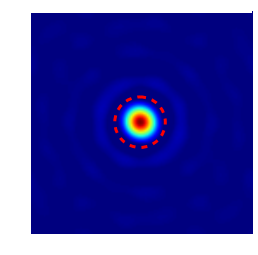

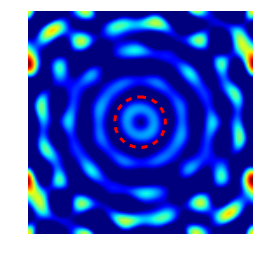

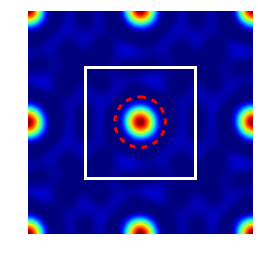

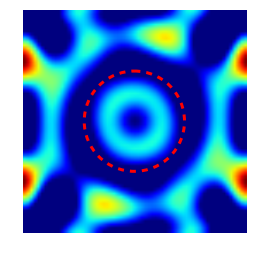

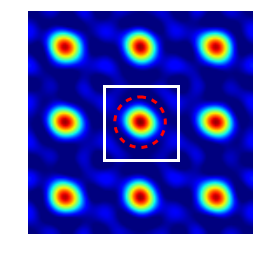

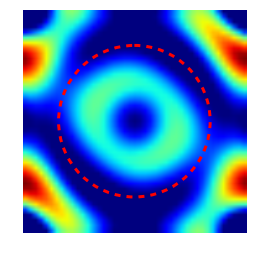

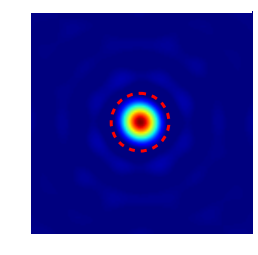

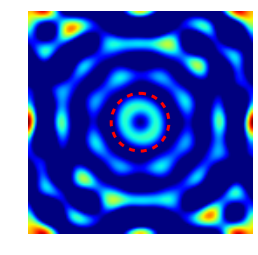

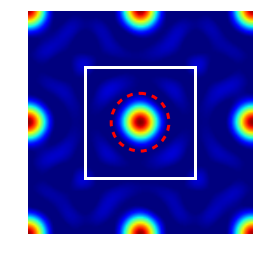

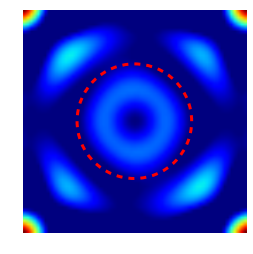

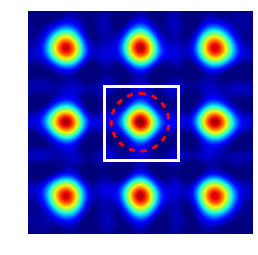

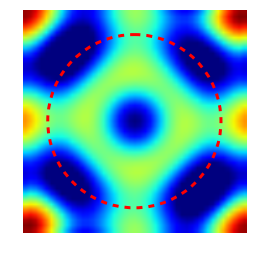

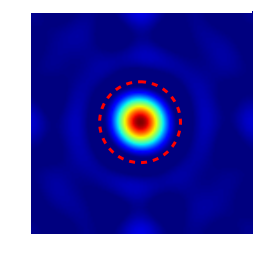

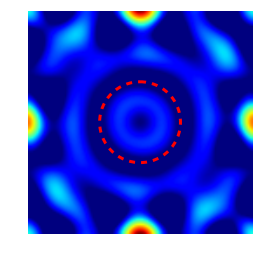

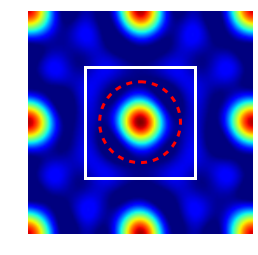

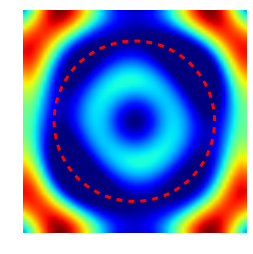

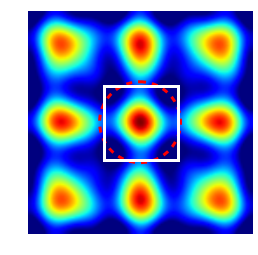

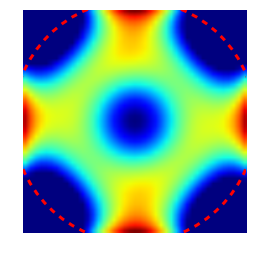

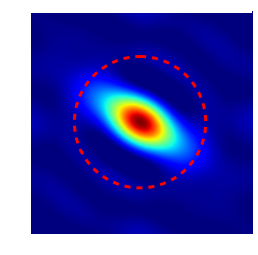

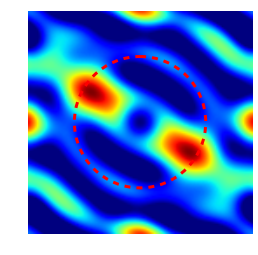

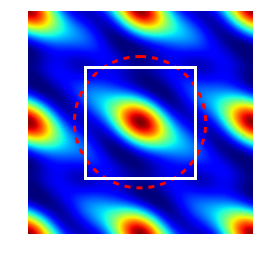

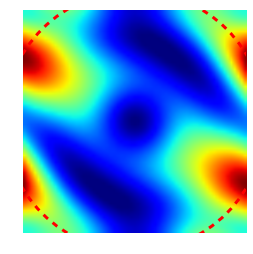

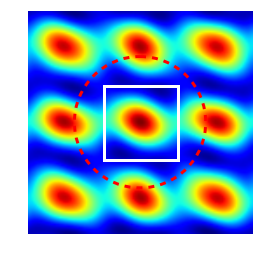

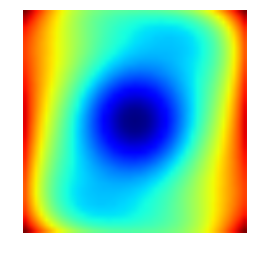

In [4]:
fnArr = np.array(['DSI17_exvivo', 'DSI15_exvivo', 'DSI11_exvivo', 'DSI11_invivo_b10k'])
downratioArr = np.array([1., 2., 3.]);
qgridsz = 129; # Q-space grid size
qgridcenter = qgridsz//2;

for ii in np.arange(fnArr.shape[0]):
    fn = fnArr[ii];
    gtab = grad.gradient_table('data/' + fn + '_bvals.txt', 'data/' + fn + '_bvecs_dipy.txt');
    mdd = np.loadtxt('data/' + fn + '_stats.txt')[0];
    fov = np.loadtxt('data/' + fn + '_stats.txt')[1];
    
    for jj in np.arange(downratioArr.shape[0]):
        downratio = downratioArr[jj];
        
        data = nib.load('data/' + fn + '_sfib.nii.gz').get_data(); # Load data again
        downdata = downsample(data, gtab, downratio); 
        
        intdist = np.min([mdd, fov / downratio / 2.]) 
        rend = intdist / fov * qgridsz;

        dsimodel = dsi.DiffusionSpectrumModel(gtab, qgrid_size=qgridsz, filter_width=np.inf, filter_type='none', r_start=0, r_end=rend, r_step=0.2);
        dsifit = dsimodel.fit(downdata);

        # ODF peaks
        dsipeaks = peaks_from_model(dsimodel, data[0, 0, 0], sphere,
                         relative_peak_threshold=0.23,
                         min_separation_angle=25, normalize_peaks=True, return_odf=True)
        
        # ODF
        odfvox = dsipeaks.odf;

        # PDF
        pdf = dsifit.pdf(normalized=False, clipped=False); 
        pdfvox = pdf[0, 0, 0]

        pdfvox = pdfvox / pdfvox.max()
        pdfslice = np.fliplr(np.rot90(pdfvox[:, qgridcenter, :]))
        pdfslice_clipped = np.clip(pdfslice, 0, pdfslice.max())

        # Weighted PDF
        pdf_weighted = dsifit.pdf_weighted(); 
        pdfvox_weighted = pdf_weighted[0, 0, 0]

        pdfvox_weighted = pdfvox_weighted / pdfvox_weighted.max()
        pdfslice_weighted = np.fliplr(np.rot90(pdfvox_weighted[:, qgridcenter, :]))
        pdfslice_weighted_clipped = np.clip(pdfslice_weighted, 0, pdfslice_weighted.max())
        pdfslice_weighted_clipped_fov = pdfslice_weighted_clipped[qgridsz//2-qgridsz//(2*downratio): qgridsz//2+qgridsz//(2*downratio)+1, qgridsz//2-qgridsz//(2*downratio): qgridsz//2+qgridsz//(2*downratio)+1];

        # Save ODF
        r = fvtk.ren();
        fvtk.add(r, fvtk.sphere_funcs(odfvox, sphere));
        fvtk.camera(r, pos=(0, 1, 0), viewup=(0, 0, 1))
        odfname = 'figure7/' + fn + '_odf_ratio_' + str(downratio) + '.png';
        fvtk.record(r, n_frames=1, out_path=odfname, size=(600,600))
        #fvtk.show(r)
        
        # Save ODF peaks
        r = fvtk.ren();
        fvtk.add(r, fvtk.peaks(dsipeaks.peak_dirs, dsipeaks.peak_values, scale=2.2))
        fvtk.camera(r, pos=(0, 1, 0), viewup=(0, 0, 1))
        if downratio == 3.:
            fvtk.camera(r, pos=(0.1, 1, 0), viewup=(0, 0, 1))
        odfpeaksname = 'figure7/' + fn + '_odfpeaks_ratio_' + str(downratio) + '.png';
        fvtk.record(r, n_frames=1, out_path=odfpeaksname, size=(600,600))
        #fvtk.show(r)

        # Save PDF
        fig = figure()
        imshow(pdfslice_clipped);
        circle = Circle((qgridsz//2, qgridsz//2), radius = mdd / fov * qgridsz, color = 'r', fill=False, linestyle = 'dashed', linewidth=3.)
        fig.gca().add_artist(circle)
        rect = Rectangle((qgridsz//2-qgridsz//(2*downratio), qgridsz//2-qgridsz//(2*downratio)), qgridsz//downratio, qgridsz//downratio, fill=False, color='w', linestyle = 'solid', linewidth=3.)
        fig.gca().add_artist(rect)
        axis('off');
        pdfname = 'figure7/' + fn + '_pdf_ratio_' + str(downratio) + '.png';
        savefig(pdfname, dpi = 600)

        # Save weighted PDF
        fig = figure()
        imshow(pdfslice_weighted_clipped_fov);
        circle = Circle((qgridsz//(2*downratio), qgridsz//(2*downratio)), radius = mdd / fov * qgridsz, color = 'r', fill=False, linestyle = 'dashed', linewidth=3.)
        fig.gca().add_artist(circle)
        axis('off');
        pdfname = 'figure7/' + fn + '_weightedpdf_ratio_' + str(downratio) + '.png';
        savefig(pdfname, dpi = 600)
